## Method #1 VOD Logit Benchmark

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from time import time

In [42]:
cd

/Users/karatechop


In [43]:
cd /Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022\ \(CSV\)

/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022 (CSV)


In [44]:
df = pd.read_csv('working_main_expanded.csv')
print(df.columns,'\n',df.shape)

Index(['date', 'day_in_year', 'time', 'sunsettime', 'dusktime', 'sex', 'race',
       'type', 'duration', 'agency', 'location', 'city', 'lat', 'lon', 'wave',
       'mins_stop_time', 'mins_dawn', 'mins_sunrise', 'mins_sunset',
       'mins_dusk', 'mins_after_dawn', 'mins_before_dusk', 'dark'],
      dtype='object') 
 (2408246, 23)


In [177]:
df[df['dark']==1].shape

(819770, 23)

Let's find the earliest and latest dark periods for dawn and dusk to filter for our ITP

In [45]:
itp_dawn = df[(df['type']!='Non-Moving') &
             ((df['mins_stop_time']>=df.mins_dawn.min()) & (df['mins_stop_time']<=df.mins_dawn.max())) & #filtering for ITP (4:30-8:30)
             ((df['mins_after_dawn']>=30) | (df['mins_after_dawn']<=0))][['date', #removing sunset->dusk period
                                                                          'time',
                                                                          'race',
                                                                          'location',
                                                                          'city',
                                                                          'wave',
                                                                          'mins_after_dawn',
                                                                          'mins_stop_time',
                                                                          'mins_dawn',
                                                                          'dark']]

itp_dawn['period'] = 'dawn'
itp_dawn.shape
itp_dawn.to_csv('itp_dawn.csv',index=False)

In [46]:
itp_dusk = df[(df['type']!='Non-Moving') &
             ((df['mins_stop_time']>=df.mins_dusk.min()) & (df['mins_stop_time']<=df.mins_dusk.max())) & #filtering for ITP (4:30-8:30)
             ((df['mins_before_dusk']>=30) | (df['mins_before_dusk']<=0))][['date', #removing sunset->dusk period
                                                                            'time',
                                                                            'race',
                                                                            'location',
                                                                            'city',
                                                                            'wave',
                                                                            'mins_before_dusk',
                                                                            'mins_stop_time',
                                                                            'mins_dusk',
                                                                            'dark']]
itp_dusk['period'] = 'dusk'
itp_dusk.shape
itp_dusk.to_csv('itp_dusk.csv',index=False)

In [47]:
itp_dusk.shape

(337580, 11)

In [48]:
itp_full = pd.concat([itp_dawn,itp_dusk]).drop(columns=['mins_after_dawn','mins_before_dusk','mins_dawn','mins_dusk'])
itp_full.to_csv('itp_full.csv',index=False)
itp_full.isna().sum()

date              0
time              0
race              0
location          0
city              0
wave              0
mins_stop_time    0
dark              0
period            0
dtype: int64

In [15]:
itp_full.shape

(419353, 9)

## VOD 

In [49]:
import scipy
import statsmodels.formula.api as smf
import statistics as st 

### Statewide VOD Model

In [50]:
#https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/
vod_ca_dusk = pd.get_dummies(itp_dusk, columns = ['race'], drop_first=True, prefix='')\
                       [['date',
                         'location',
                         'city',
                         'wave',
                         'dark',
                             'mins_stop_time',
                             '_hispanic/latino(a)',
                         '_black/african american']].reset_index(drop=True)
                                                    .rename(columns={'_black/african american':'black',
                                                                     '_hispanic/latino(a)':'hispanic'})\
                                                    
vod_ca_dusk.head(2)
# vod_ca_full.shape

,date,location,city,wave,dark,mins_stop_time,hispanic,black
0,2021-03-12 00:00:00,1100 block of william ct - San Jose,San Jose,2,0,1054.0,1,0
1,2021-01-21 00:00:00,1500 block of moorpark - San Jose,San Jose,2,1,1215.0,0,0


In [52]:
formula = f"black ~ C(dark, Treatment(reference=0))"
log_reg = smf.logit(formula, data = vod_ca_dusk[vod_ca_dusk['wave']==1]).fit()
results = log_reg.summary()
OR = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    },
)
OR = np.exp(OR)

print(f'{OR}\n\n\n{results}\n\n\n\n\n\n\n\n\n')

Optimization terminated successfully.
         Current function value: 0.578552
         Iterations 5
                                            OR  Lower CI  Upper CI
Intercept                             0.038681  0.032973  0.045378
C(dark, Treatment(reference=0))[T.1]  0.964845  0.944499  0.985629
mins_stop_time                        1.001965  1.001820  1.002110


                           Logit Regression Results                           
Dep. Variable:                  black   No. Observations:               322245
Model:                          Logit   Df Residuals:                   322242
Method:                           MLE   Df Model:                            2
Date:                Wed, 16 Nov 2022   Pseudo R-squ.:                0.002933
Time:                        07:17:50   Log-Likelihood:            -1.8644e+05
converged:                       True   LL-Null:                   -1.8698e+05
Covariance Type:            nonrobust   LLR p-value:                6.802e-

### LA MODEL FULL

In [124]:
# test = pd.read_csv('la_final_seasonal.csv')
test = pd.read_csv('la_final_non_seasonal.csv')
test_bw = test[(test['race']=='black/african american') | (test['race']=='white')]
test_hw = test[(test['race']=='hispanic/latino(a)') | (test['race']=='white')]


In [125]:
test_bw['race'].unique()

array(['black/african american', 'white'], dtype=object)

In [126]:
test_bw.columns

Index(['date', 'time', 'race', 'location', 'city', 'wave', 'mins_before_dusk',
       'mins_stop_time', 'mins_dusk', 'dark', 'period', 'coords', 'tract',
       'pop_level', 'freq_level', 'dst1', 'dst2', 'diff_dst1', 'diff_dst2'],
      dtype='object')

In [128]:
#https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/
vod_la_dusk_bw = pd.get_dummies(test_bw, columns = ['race'], drop_first=False, prefix='')\
                       [['date',
                         'tract',
                         'pop_level',
                         'freq_level',
                         'wave',
                         'dark',
                         'mins_stop_time',
                         'mins_before_dusk',
                         'mins_dusk',
                         '_black/african american']].rename(columns={'_black/african american':'black'})\
                                                    .reset_index(drop=True)
vod_la_dusk_bw.head(2)
# vod_ca_full.shape

,date,tract,pop_level,freq_level,wave,dark,mins_stop_time,mins_before_dusk,mins_dusk,black
0,2018-07-02,2089.03,mid,high,1,0,1050.0,188.0,1238.0,1
1,2018-07-07,2089.03,mid,high,1,0,1174.0,63.0,1237.0,1


In [142]:
#https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/
vod_la_dusk_hw = pd.get_dummies(test_hw, columns = ['race'], drop_first=False, prefix='')\
                       [['date',
                         'tract',
                         'pop_level',
                         'freq_level',
                         'wave',
                         'dark',
                         'mins_before_dusk',
                         'mins_stop_time',
                         'mins_dusk',
                         '_hispanic/latino(a)']].rename(columns={'_hispanic/latino(a)':'hispanic'})\
                                                    .reset_index(drop=True)
vod_la_dusk_hw.head(2)
# vod_ca_full.shape

,date,tract,pop_level,freq_level,wave,dark,mins_before_dusk,mins_stop_time,mins_dusk,hispanic
0,2018-07-01,2089.03,mid,high,1,0,93.0,1145.0,1238.0,1
1,2018-07-02,2089.03,mid,high,1,0,78.0,1160.0,1238.0,1


In [150]:
vod_la_dusk_bw.corr(method='pearson')

,tract,wave,dark,mins_stop_time,mins_before_dusk,mins_dusk,black
tract,1.000000,NaN,-0.031131,-0.031665,0.026712,0.007744,0.121996
wave,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dark,-0.031131,NaN,1.000000,0.681980,-0.850129,-0.584324,0.047175
mins_stop_time,-0.031665,NaN,0.681980,1.000000,-0.756454,-0.112191,0.095150
mins_before_dusk,0.026712,NaN,-0.850129,-0.756454,1.000000,0.734785,-0.059352
mins_dusk,0.007744,NaN,-0.584324,-0.112191,0.734785,1.000000,0.008506
black,0.121996,NaN,0.047175,0.095150,-0.059352,0.008506,1.000000


In [143]:
print(vod_la_dusk_bw.shape[0],vod_la_dusk_hw.shape[0])

53713 104883


In [158]:
    formula = f"hispanic ~ C(dark, Treatment(reference=0))  + mins_stop_time\
                                                        + C(pop_level, Treatment(reference=1))\
                                                        + C(freq_level, Treatment(reference=1))"
log_reg = smf.logit(formula, data = vod_la_dusk_hw).fit()
results = log_reg.summary()
OR = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    },
)
OR = np.exp(OR)

print(f'{OR}\n\n\n{results}\n\n\n\n\n\n\n\n\n')

Optimization terminated successfully.
         Current function value: 0.460583
         Iterations 6
                                                     OR  Lower CI  Upper CI
Intercept                                      0.145826  0.105169  0.202200
C(dark, Treatment(reference=0))[T.1]           0.895309  0.857755  0.934507
C(pop_level, Treatment(reference=1))[T.high]   1.368218  1.249010  1.498803
C(pop_level, Treatment(reference=1))[T.mid]    1.351982  1.298734  1.407413
C(freq_level, Treatment(reference=1))[T.high]  2.693084  2.533152  2.863114
C(freq_level, Treatment(reference=1))[T.mid]   1.473467  1.381153  1.571950
mins_stop_time                                 1.002171  1.001878  1.002463


                           Logit Regression Results                           
Dep. Variable:               hispanic   No. Observations:               104883
Model:                          Logit   Df Residuals:                   104876
Method:                           MLE   Df Model:  

In [165]:
vod_la_dusk_bw.corr(method='pearson')

,tract,wave,dark,mins_stop_time,mins_before_dusk,mins_dusk,black
tract,1.000000,NaN,-0.031131,-0.031665,0.026712,0.007744,0.121996
wave,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dark,-0.031131,NaN,1.000000,0.681980,-0.850129,-0.584324,0.047175
mins_stop_time,-0.031665,NaN,0.681980,1.000000,-0.756454,-0.112191,0.095150
mins_before_dusk,0.026712,NaN,-0.850129,-0.756454,1.000000,0.734785,-0.059352
mins_dusk,0.007744,NaN,-0.584324,-0.112191,0.734785,1.000000,0.008506
black,0.121996,NaN,0.047175,0.095150,-0.059352,0.008506,1.000000


In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
formula = f"black ~ C(dark, Treatment(reference=0)) + mins_stop_time\
                                                    + C(pop_level, Treatment(reference=1))\
                                                    + C(freq_level, Treatment(reference=1))"
log_reg = smf.logit(formula, data = vod_la_dusk_bw).fit()
results = log_reg.summary()
OR = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    },
)
OR = np.exp(OR)

print(f'{OR}\n\n\n{results}\n\n\n\n\n\n\n\n\n')

NameError: name 'pd' is not defined

In [ ]:
#PSUEDO
# C(location_POP, Treatment(reference=0) low/medium/high population area, 3 levels
# C(location_FREQ, Treatment(reference=0) low/medium/high stop frequency area, 3 levels
# TABLE GOING INTO PSEUDO SHOULD HAVE 8 COLS (DEP, DARK (1), LOC(3), POP(3))

psuedo_formula = f"black ~ dark + C(location_FREQ, Treatment(reference=0)) + C(location_POP, Treatment(reference=0))"


### By City

In [341]:
la = vod[vod['city'] == 'Los Angeles'].reset_index(drop=True)
la.head(2)
la['location'] = [i.lower().lstrip('').rstrip('') for i in la['location']]
locations_la = la['location'].unique()
len(locations_la)

57260

## Method #2 Proportions Before/After Sunset

In [66]:
cd

/Users/karatechop


In [67]:
cd /Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022\ \(CSV\)

/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022 (CSV)


In [68]:
# itp_dawn
# itp_dusk
# itp_full

In [80]:
print(itp_dusk.columns)
itp_dusk.head(2)

Index(['date', 'race', 'location', 'city', 'mins_before_dusk',
       'mins_stop_time', 'mins_dusk', 'dark'],
      dtype='object')


,date,race,location,city,mins_before_dusk,mins_stop_time,mins_dusk,dark
27,2021-03-12 00:00:00,hispanic/latino(a),1100 block of william ct - San Jose,San Jose,65.000,1054.000,1119.000,0
79,2021-01-30 00:00:00,hispanic/latino(a),1300 block of sthal street - San Jose,San Jose,28.000,1050.000,1078.000,0


## CA

In [174]:
df1_bw.race.unique()

array(['hispanic/latino(a)', 'black/african american', 'white', 'asian',
       'group 4'], dtype=object)

In [5]:
test = pd.read_csv('la_final_seasonal.csv')

In [195]:
df1_bw = itp_dusk[(itp_dusk['mins_before_dusk'] <= 95) &\
                  (itp_dusk['mins_before_dusk'] >= -95)] #&\
#                   (itp_dusk['city']=='Los Angeles')]
#         (df['type']=='Moving')][['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset']]

df1_bw['before_dusk_category'] = [min(np.arange(-90,91,10), key=lambda x:abs(x-i)) for i in df1_bw['mins_before_dusk']]
prop_table = df1_bw.groupby('before_dusk_category',as_index=False).agg('count')[['before_dusk_category','race']]


#############################################
prop_table['black_aa_stops'] = df1_bw[df1_bw['race']=='black/african american'].groupby('before_dusk_category',as_index=False)\
                                                                   .agg('count')[['before_dusk_category','race']]\
                                                                   .rename(columns={'race':'black_aa'})['black_aa']
prop_table['prop_black_aa'] = round(prop_table['black_aa_stops']/prop_table['race'],4)




prop_table['white_stops'] = df1_bw[df1_bw['race']=='white'].groupby('before_dusk_category',as_index=False)\
                                                                   .agg('count')[['before_dusk_category','race']]\
                                                                   .rename(columns={'race':'white'})['white']
prop_table['prop_white'] = round(prop_table['white_stops']/prop_table['race'],4)




prop_table['hispanic_stops'] = df1_bw[df1_bw['race']=='hispanic/latino(a)'].groupby('before_dusk_category',as_index=False)\
                                                                   .agg('count')[['before_dusk_category','race']]\
                                                                   .rename(columns={'race':'hispanic'})['hispanic']
prop_table['prop_hispanic'] = round(prop_table['hispanic_stops']/prop_table['race'],4)

#############################################


prop_table = prop_table.sort_values(by='before_dusk_category',ascending=False)\
                       .reset_index(drop=True)\
                       .rename(columns={'race':'total_stops'})[['before_dusk_category', 'total_stops', 
                                                                'white_stops','black_aa_stops', 'hispanic_stops',
                                                                'prop_white','prop_black_aa','prop_hispanic']]

prop_table_pre = prop_table[(prop_table['before_dusk_category']>=30)]
prop_table_dusk = prop_table[(prop_table['before_dusk_category']<= 0)]
prop_table

/var/folders/td/yc8lq2qx2ks3ck292tbf6wtm0000gn/T/ipykernel_6220/2521869304.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_bw['before_dusk_category'] = [min(np.arange(-90,91,10), key=lambda x:abs(x-i)) for i in df1_bw['mins_before_dusk']]


,before_dusk_category,total_stops,white_stops,black_aa_stops,hispanic_stops,prop_white,prop_black_aa,prop_hispanic
0,90,9962,1805,2482,4697,0.181,0.249,0.471
1,80,10550,1811,2639,5109,0.172,0.250,0.484
2,70,10645,1875,2678,5084,0.176,0.252,0.478
3,60,11242,1824,2919,5512,0.162,0.260,0.490
4,50,11793,1905,3033,5704,0.162,0.257,0.484
5,40,12348,1946,3247,6035,0.158,0.263,0.489
6,30,7517,1164,2025,3645,0.155,0.269,0.485
7,0,7519,1286,2014,3529,0.171,0.268,0.469
8,-10,15012,2449,4197,6991,0.163,0.280,0.466
9,-20,14985,2449,4185,7067,0.163,0.279,0.472


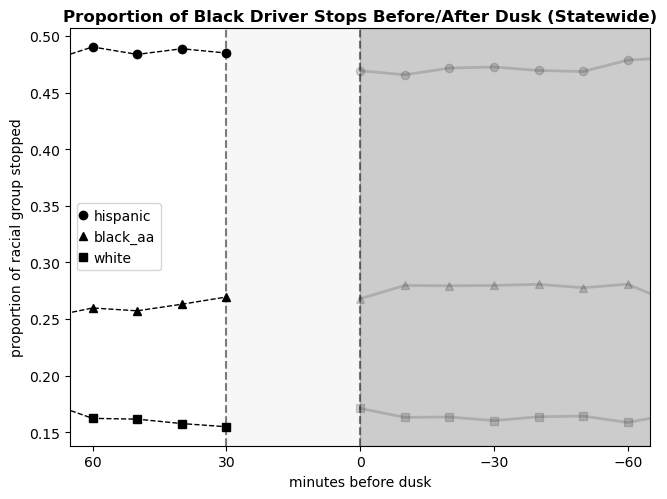

In [222]:
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
fig,ax=plt.subplots()


ax.plot(prop_table_pre['before_dusk_category'],prop_table_pre['prop_hispanic'],linewidth=1,c='black',label='hispanic',marker="o",linestyle='--')
ax.plot(prop_table_pre['before_dusk_category'],prop_table_pre['prop_black_aa'],linewidth=1,c='black',label='black_aa',marker="^",linestyle='--')
ax.plot(prop_table_pre['before_dusk_category'],prop_table_pre['prop_white'],linewidth=1,c='black',label='white',marker="s",linestyle='--')



# ax.scatter(prop_table_sunset['before_dusk_category'],prop_table_sunset['prop'],linewidth=2,c='black',label='reported stops',marker="o")
ax.plot(prop_table_dusk['before_dusk_category'],prop_table_dusk['prop_hispanic'],linewidth=2,c='black',alpha=.15,marker="o")
ax.plot(prop_table_dusk['before_dusk_category'],prop_table_dusk['prop_black_aa'],linewidth=2,c='black',alpha=.15,marker="^")
ax.plot(prop_table_dusk['before_dusk_category'],prop_table_dusk['prop_white'],linewidth=2,c='black',alpha=.15,marker="s")


ax.set_ylabel("proportion of racial group stopped")
ax.set_xlabel('minutes before dusk')


plt.xticks(np.arange(90,-91,-30))
ax.invert_xaxis()

plt.xlim(65,-65)
plt.axvline(x = 30,c='black',alpha=.5,linestyle='dashed')
plt.axvline(x = 0,c='black',alpha=.5,linestyle='dashed')
plt.axvspan(30, 0, color='black', alpha=0.03)
plt.axvspan(0, -95, color='black', alpha=0.2)


plt.title('Proportion of Black Driver Stops Before/After Dusk (Statewide)',weight='semibold',pad=5)
plt.legend()
plt.tight_layout(pad=0, w_pad=2, h_pad=2)

plt.show()

# save the plot as a file
# fig.savefig('/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Notebooks/Exports/Total Stops vs Proportion Black Civil Twilight (CA).jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

In [197]:
df1_bw = df1_bw.reset_index(drop=True)

light = df1_bw[(df1_bw['dark']==0)&\
              ((df1_bw['mins_before_dusk'] >-15) | (df1_bw['mins_before_dusk'] < 15))]
prop_light = (light[light['race'] == 'black/african american']).shape[0]/light.shape[0]

dark = df1_bw[(df1_bw['dark']==1)&\
              ((df1_bw['mins_before_dusk'] >-15) | (df1_bw['mins_before_dusk'] < 15))]
prop_dark = (dark[dark['race'] == 'black/african american']).shape[0]/dark.shape[0]

print(f'light:{prop_light}\n dark:{prop_dark}')

light:0.2568697084678018
 dark:0.2756760495193305


In [132]:
# grouped_hours = hour_test[(hour_test['mins_stop_time']>=(60*15))&(hour_test['mins_stop_time']<=(60*22))]
# plt.xticks(np.arange(0,(60*24.5),60),rotation=60)

# for i in hour_test.race.unique():
#     grouped_hours = hour_test[hour_test['race']==i].groupby('mins_stop_time',as_index=False).agg('count')[['mins_stop_time','race']]
#     plt.plot(grouped_hours.mins_stop_time,grouped_hours.race,label=f'{i}')

# # plt.axvline(x = 1020,c='black',alpha=.8,linestyle='dashed')
# # plt.axvline(x = 1200,c='black',alpha=.8,linestyle='dashed')
# # plt.axvspan(0, 1020, color='black', alpha=0.2)
# # plt.axvspan(1200, 1440, color='black', alpha=0.2)
# plt.axvline(x = 1020,c='black',alpha=.8,linestyle='dashed')
# plt.axvspan(1020, 1440, color='black', alpha=0.2)

# plt.axvline(x = 1200,c='black',alpha=.4,linestyle='dashed')
# plt.axvspan(1200, 1440, color='black', alpha=0.35)

# plt.xlim(360,1440)
# plt.ylim(0,2000)

# plt.legend(fontsize=6,borderpad=1,loc='upper left')

In [179]:
itp_full[itp_full['dark']==1].shape

(210791, 9)

In [116]:
test = pd.read_csv('la_final_non_seasonal.csv')

In [170]:
test.shape

(149655, 19)

In [171]:
test2 = pd.read_csv('la_final_seasonal.csv')
test2.shape

(44871, 19)

In [117]:
test['race'].unique()

array(['hispanic/latino(a)', 'black/african american', 'group 4', 'white',
       'asian'], dtype=object)

In [121]:
df1_bw = test[((test['mins_before_dusk'] <= 95) & (test['mins_before_dusk'] >= -95)) &\
              ((test['race']=='black/african american') | (test['race']=='white'))] #&\
print(df1_bw.shape)
#                   (itp_dusk['city']=='Los Angeles')]
#         (df['type']=='Moving')][['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset']]

df1_bw['before_dusk_category'] = [min(np.arange(-90,91,10), key=lambda x:abs(x-i)) for i in df1_bw['mins_before_dusk']]
prop_table = df1_bw.groupby('before_dusk_category',as_index=False).agg('count')[['before_dusk_category','race']]


#############################################
prop_table['black_aa_stops'] = df1_bw[df1_bw['race']=='black/african american'].groupby('before_dusk_category',as_index=False)\
                                                                   .agg('count')[['before_dusk_category','race']]\
                                                                   .rename(columns={'race':'black_aa'})['black_aa']
prop_table['prop_black_aa'] = round(prop_table['black_aa_stops']/prop_table['race'],4)



#############################################


prop_table = prop_table.sort_values(by='before_dusk_category',ascending=False)\
                       .reset_index(drop=True)\
                       .rename(columns={'race':'total_stops'})[['before_dusk_category', 'total_stops', 
                                                                'black_aa_stops','prop_black_aa']]

prop_table_pre = prop_table[(prop_table['before_dusk_category']>=30)]
prop_table_dusk = prop_table[(prop_table['before_dusk_category']<= 0)]
prop_table

(30475, 19)


/var/folders/td/yc8lq2qx2ks3ck292tbf6wtm0000gn/T/ipykernel_18675/2096169669.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_bw['before_dusk_category'] = [min(np.arange(-90,91,10), key=lambda x:abs(x-i)) for i in df1_bw['mins_before_dusk']]


,before_dusk_category,total_stops,black_aa_stops,prop_black_aa
0,90,1546,981,0.6345
1,80,1602,1021,0.6373
2,70,1649,1053,0.6386
3,60,1785,1197,0.6706
4,50,1828,1193,0.6526
5,40,1941,1280,0.6595
6,30,1155,791,0.6848
7,0,1260,801,0.6357
8,-10,2525,1668,0.6606
9,-20,2478,1640,0.6618


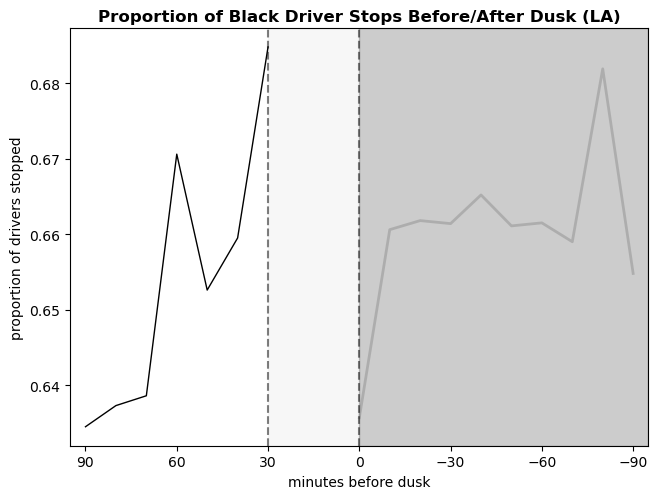

In [167]:
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
fig,ax=plt.subplots()


ax.plot(prop_table_pre['before_dusk_category'],prop_table_pre['prop_black_aa'],linewidth=1,c='black',label='black_aa')
# ax.scatter(prop_table_sunset['before_dusk_category'],prop_table_sunset['prop'],linewidth=2,c='black',label='reported stops',marker="o")
ax.plot(prop_table_dusk['before_dusk_category'],prop_table_dusk['prop_black_aa'],linewidth=2,c='black',alpha=.15)


ax.set_ylabel("proportion of drivers stopped")
ax.set_xlabel('minutes before dusk')


plt.xticks(np.arange(90,-91,-30))
ax.invert_xaxis()

plt.xlim(95,-95)
plt.axvline(x = 30,c='black',alpha=.5,linestyle='dashed')
plt.axvline(x = 0,c='black',alpha=.5,linestyle='dashed')
plt.axvspan(30, 0, color='black', alpha=0.03)
plt.axvspan(0, -95, color='black', alpha=0.2)


plt.title('Proportion of Black Driver Stops Before/After Dusk (LA)',weight='semibold',pad=5)
# plt.legend()
plt.tight_layout(pad=0, w_pad=2, h_pad=2)

plt.show()

# save the plot as a file
# fig.savefig('/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Notebooks/Exports/Total Stops vs Proportion Black Civil Twilight (CA).jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')